# Continuous Time FW
## Huber Regression with nuclear norm constraints

In [1]:
import numpy as np
from numpy.linalg import norm
import pylab as plt
from scipy import sparse
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse.linalg import svds
from frank_wolfe import FW_matfact

In [2]:
data = pd.read_csv('data/movielens100k.csv', names=['user id', 'item id', 'rating', 'timestamp'])
B = np.double(pd.pivot_table(data, values='rating', index='user id', columns='item id').values)-3.
BI,BJ = np.where(np.logical_not(np.isnan(B)))

In [3]:
def huber(t,rho):
    x = t*0.
    x[np.less_equal(np.abs(t),rho)] = np.power(t[np.less_equal(np.abs(t),rho)],2.)/2.
    x[np.greater(np.abs(t),rho)] = np.abs(x[np.greater(np.abs(t),rho)] -rho) + np.power(rho,2.)/2.
    return x

def der_huber(t,rho):
    x = t*0.
    x[np.less_equal(np.abs(t),rho)] = t[np.less_equal(np.abs(t),rho)]
    x[np.greater(t,rho)] = rho
    x[np.less(t,-rho)] = -rho
    return x

def get_atom(G):
    u, s, v = svds(G, k=1, which='LM')
    return np.outer(u, v)

def obj_fun(x, rho):
    return np.sum(huber(np.nan_to_num(B-x),rho))

def dFun(x,alpha,rho):
    grad = der_huber(np.nan_to_num(x-B), rho)
    S = get_atom(-grad)*alpha
    d = S-x.copy()
    return d, grad

def dFun_mom(x,alpha,rho, theta,y,v, gamma):
    y = x * (1.-gamma) + gamma * v
    grady = der_huber(np.nan_to_num(y-B), rho)
    theta = theta * (1.-gamma) + gamma * grady
    v = get_atom(-theta)*alpha
    d = v-x
    return d, grady, theta,y,v

In [5]:
alpha = 1000.
rho = 10.
T=100

def obj_fun_2(z) : return obj_fun(z, rho)
# disc_type can be 'FE', 'midpoint', 'rk44', 'rk4', 'rk5'
sol = FW_matfact(obj_fun_2, dFun, dFun_mom, B.shape, alpha,rho, T=T, n=T, disc_type ='FE', line_search = False, momentum = False)

<ipython-input-6-7c938b70959c>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-6-7c938b70959c>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


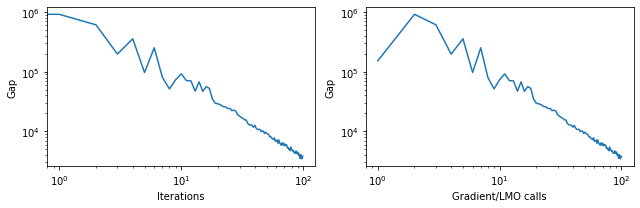

In [6]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.plot(sol[2])

plt.subplot(1,2,2)
plt.plot(sol[1],sol[2])

plt.subplot(1,2,1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Gap')

plt.subplot(1,2,2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Gradient/LMO calls')
plt.ylabel('Gap')

plt.tight_layout()